In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../data/kaggle/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# 1460 rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
from tensorflow.keras.models import load_model

In [5]:
test_df = pd.read_csv('../data/kaggle/test.csv')
test_df = pd.get_dummies(test_df)
test_df = test_df.fillna(test_df.mean())

In [6]:
cols = ['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF']
testset = test_df[cols]

In [7]:
model = load_model('../data/model/house_model.hdf5')

In [8]:
ids = []
y_pred = model.predict(testset).flatten()
for i in range(len(testset)):
    id = test_df['Id'][i]
    predict = y_pred[i]
    ids.append([id,predict])

46/46 [==============================] - 0s 2ms/step


In [9]:
sub = pd.DataFrame(ids, columns = ['Id', 'SalePrice'])
sub.head()

,Id,SalePrice
0,1461,151862.000000
1,1462,170478.250000
2,1463,182104.750000
3,1464,179674.500000
4,1465,179318.828125


In [10]:
sub.to_csv('../data/kaggle/submission.csv', index = False)

***
***

## 전처리를 더 꼼꼼히 해서 풀어보기

In [84]:
train = pd.read_csv('../data/kaggle/train.csv', index_col = 'Id')
test_df = pd.read_csv('../data/kaggle/test.csv', index_col = 'Id')
submission = pd.read_csv('../data/kaggle/sample_submission.csv', index_col = 'Id')

In [85]:
data = train

### 타겟 변수 확인 (Distribution of Target Variable)

<Axes: xlabel='SalePrice', ylabel='Count'>

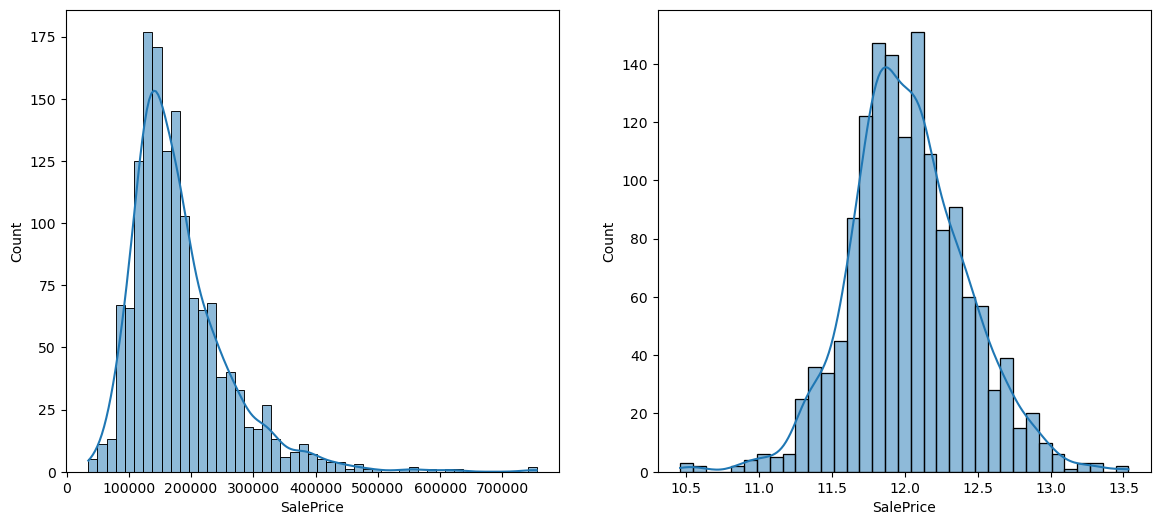

In [86]:
figure, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)
figure.set_size_inches(14,6)
sns.histplot(data['SalePrice'], kde = True, ax=ax1)
sns.histplot(np.log1p(data['SalePrice']), kde = True, ax = ax2)

C:\Users\Playdata\AppData\Local\Temp\ipykernel_1976\495902078.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


<Axes: >

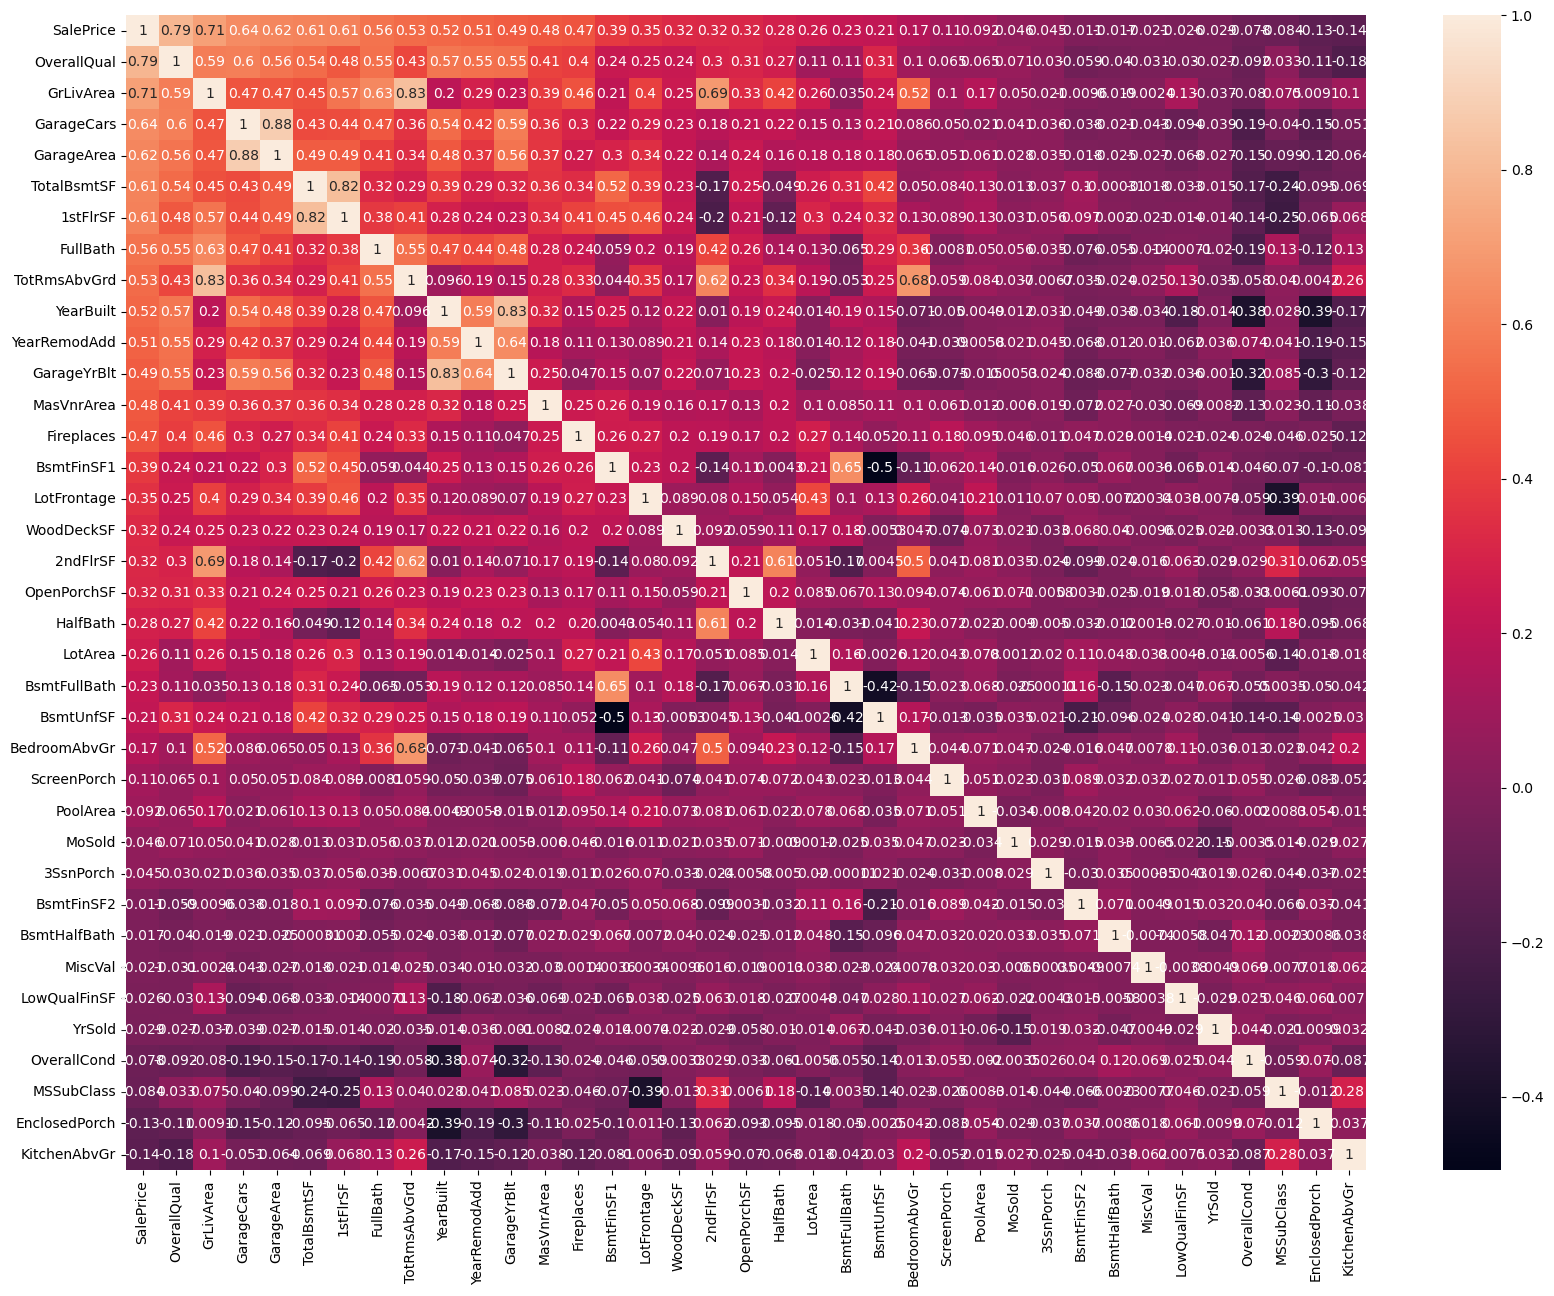

In [87]:
corr = data.corr()
top_corr = data[corr.nlargest(40, 'SalePrice')['SalePrice'].index].corr()
figure, ax1 = plt.subplots(1,1)
figure.set_size_inches(20,15)
sns.heatmap(top_corr, annot = True, ax = ax1)

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

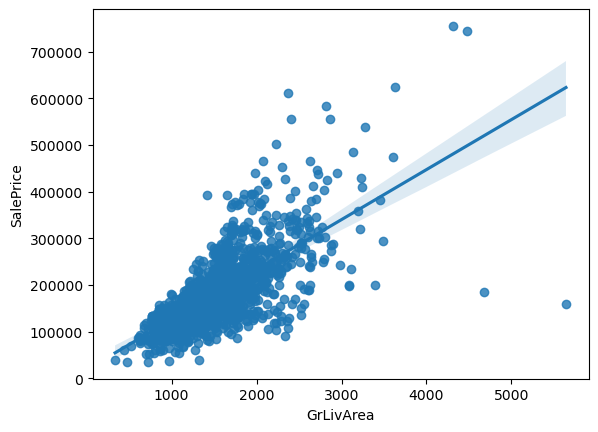

In [88]:
sns.regplot(x = data['GrLivArea'], y = data['SalePrice'])

In [89]:
# outlier 제거
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)

In [90]:
y_train = train['SalePrice']
train = train[list(test_df)]

In [91]:
all_data = pd.concat((train, test_df), axis=0)
print(all_data.shape)
y_train = np.log1p(y_train)

(2917, 79)


In [92]:
######## 35개 칼럼의 결측치 처리 ########
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea','LotFrontage'):
    all_data[col] = all_data[col].fillna(0)
    
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
    
print(f"Total count of missing values in all_data : {all_data.isnull().sum().sum()}")

Total count of missing values in all_data : 0


#### 파생 변수

<Axes: ylabel='SalePrice'>

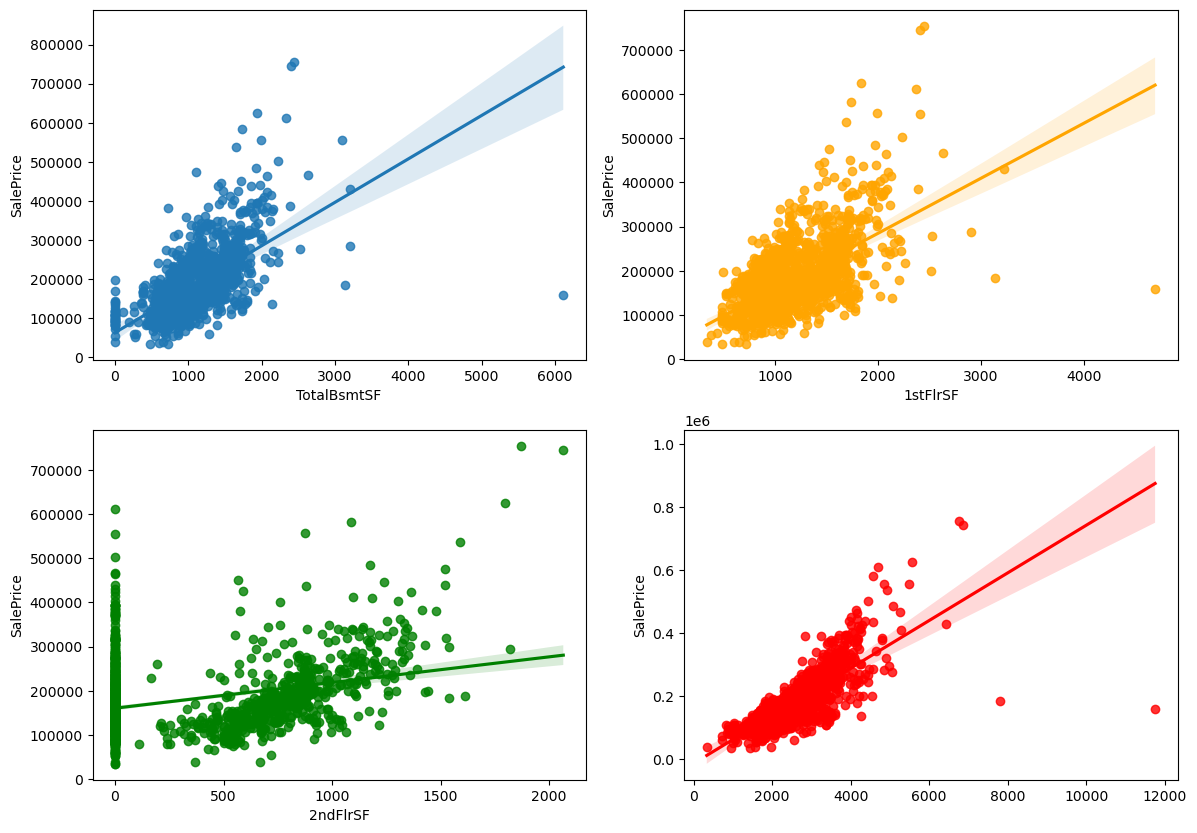

In [97]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2)
figure.set_size_inches(14,10)
sns.regplot(x = data['TotalBsmtSF'], y = data['SalePrice'], ax = ax1)
sns.regplot(x = data['1stFlrSF'], y = data['SalePrice'], color = 'orange', ax = ax2)
sns.regplot(x = data['2ndFlrSF'], y = data['SalePrice'], color = 'green', ax = ax3)
sns.regplot(x = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'], y = data['SalePrice'], color = 'red', ax = ax4)

In [98]:
# 지하실, 1층, 2층 면적을 모두 합한 총 면적 : 'TotalSF
all_data['TotalSF']=all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
# 2층과 지하실 없음 여부를 나타내는 칼럼 생성
all_data['No2ndFlr']=(all_data['2ndFlrSF']==0)
all_data['NoBsmt']=(all_data['TotalBsmtSF']==0)

<Axes: ylabel='SalePrice'>

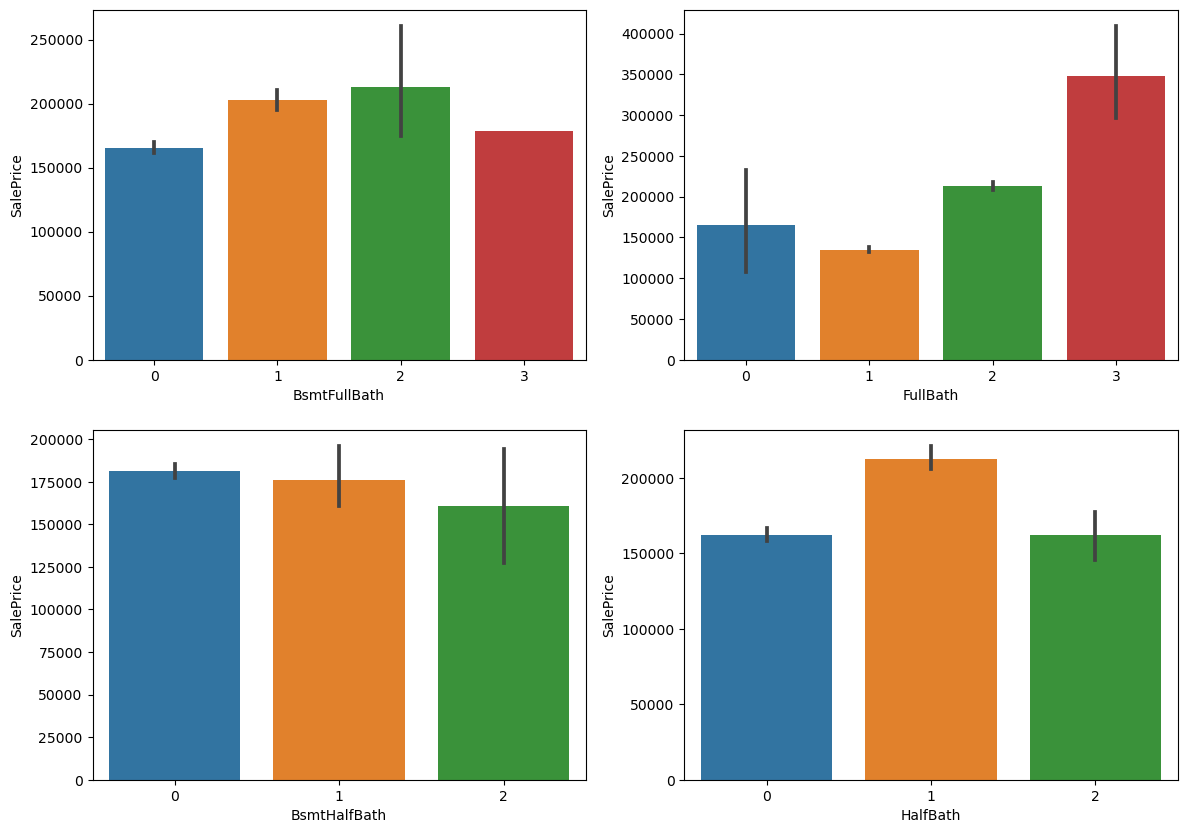

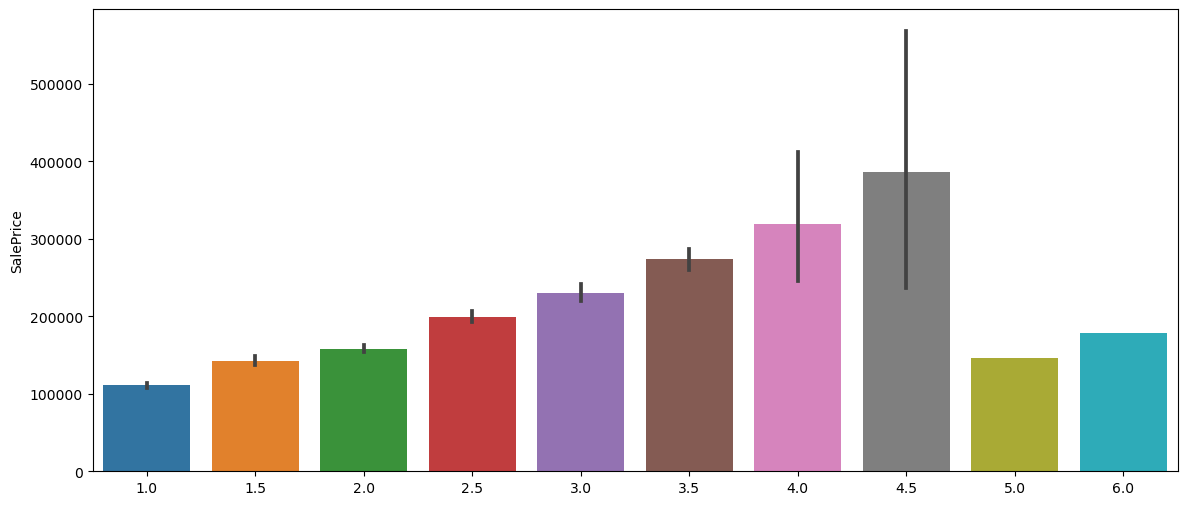

In [99]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2)
figure.set_size_inches(14,10)
sns.barplot(x = data['BsmtFullBath'], y =  data['SalePrice'], ax = ax1)
sns.barplot(x = data['FullBath'], y = data['SalePrice'], ax = ax2)
sns.barplot(x = data['BsmtHalfBath'], y = data['SalePrice'], ax = ax3)
sns.barplot(x = data['HalfBath'], y = data['SalePrice'], ax = ax4)

figure, (ax5) = plt.subplots(nrows = 1, ncols = 1)
figure.set_size_inches(14,6)
sns.barplot(x = data['BsmtFullBath'] + data['FullBath'] + (data['BsmtHalfBath']/2) + (data['HalfBath']/2), y = data['SalePrice'], ax = ax5)

In [100]:
# 총 욕실 수  : 'TotalBath'
all_data['TotalBath']=all_data['BsmtFullBath'] + all_data['FullBath'] + (all_data['BsmtHalfBath']/2) + (all_data['HalfBath']/2)

<Axes: ylabel='SalePrice'>

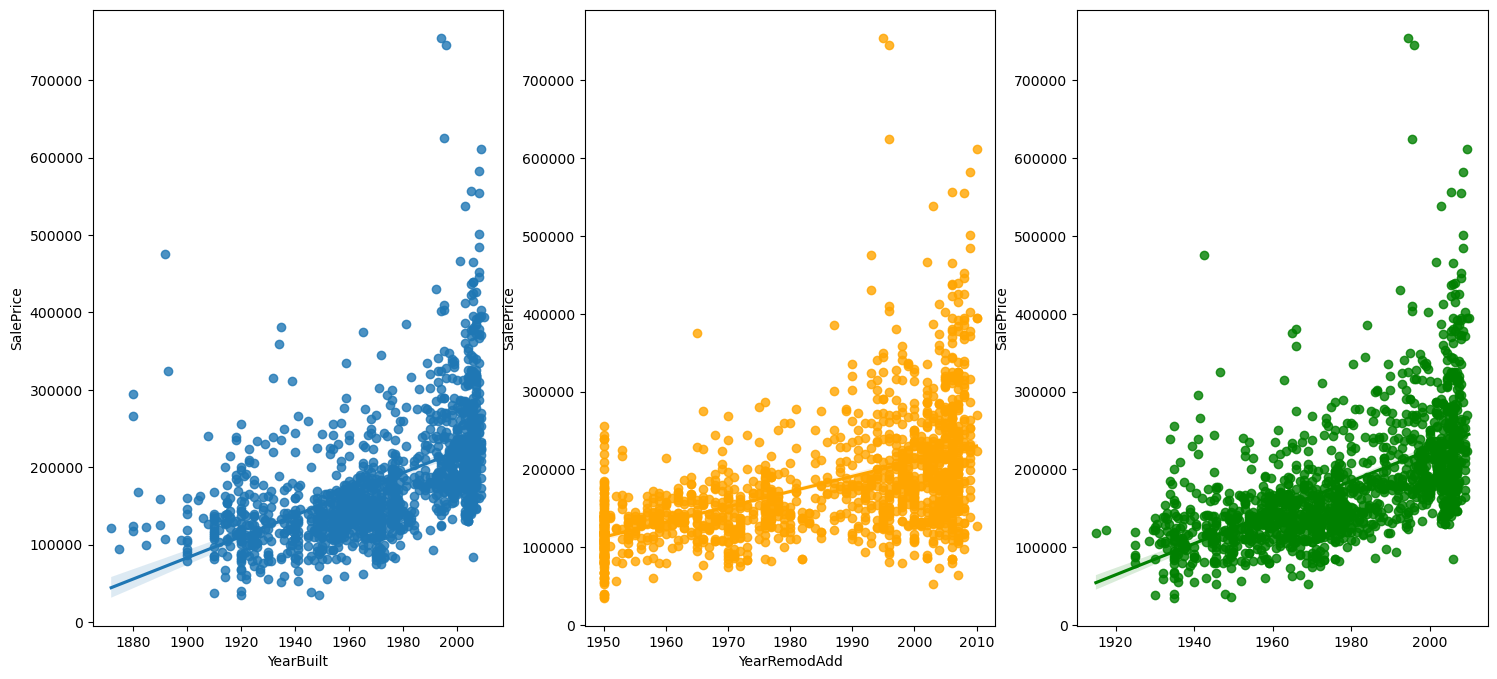

In [103]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3)
figure.set_size_inches(18,8)
sns.regplot(x = data['YearBuilt'], y = data['SalePrice'], ax = ax1)
sns.regplot(x = data['YearRemodAdd'], y = data['SalePrice'], color = 'orange', ax = ax2)
sns.regplot(x = (data['YearBuilt']+data['YearRemodAdd'])/2, y = data['SalePrice'], color = 'green', ax = ax3) #'/2' for graph scaling

In [104]:
# 'YrBltAndRemod' : 값이 높을수록 신축이고 최근에 리모델링을 한 건물
all_data['YrBltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']

#### Correcting dtypes

In [36]:
# 수치형 --> 카테고리(str)형
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)
df['MSSubClass'] = df['MSSubClass'].astype(str)    # 주거유형

#### convert condition(str) to score

In [105]:
# (1) Basement
Basement = ['BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtUnfSF', 'TotalBsmtSF']
Bsmt = all_data[Basement]

Bsmt = Bsmt.replace(to_replace='Po', value=1)
Bsmt = Bsmt.replace(to_replace='Fa', value=2)
Bsmt = Bsmt.replace(to_replace='TA', value=3)
Bsmt = Bsmt.replace(to_replace='Gd', value=4)
Bsmt = Bsmt.replace(to_replace='Ex', value=5)
Bsmt = Bsmt.replace(to_replace='None', value=0)

Bsmt = Bsmt.replace(to_replace='No', value=1)
Bsmt = Bsmt.replace(to_replace='Mn', value=2)
Bsmt = Bsmt.replace(to_replace='Av', value=3)
Bsmt = Bsmt.replace(to_replace='Gd', value=4)

Bsmt = Bsmt.replace(to_replace='Unf', value=1)
Bsmt = Bsmt.replace(to_replace='LwQ', value=2)
Bsmt = Bsmt.replace(to_replace='Rec', value=3)
Bsmt = Bsmt.replace(to_replace='BLQ', value=4)
Bsmt = Bsmt.replace(to_replace='ALQ', value=5)
Bsmt = Bsmt.replace(to_replace='GLQ', value=6)

Bsmt['BsmtScore'] = Bsmt['BsmtQual']  * Bsmt['BsmtCond'] * Bsmt['TotalBsmtSF']
all_data['BsmtScore'] = Bsmt['BsmtScore']

Bsmt['BsmtFin'] = (Bsmt['BsmtFinSF1'] * Bsmt['BsmtFinType1']) + (Bsmt['BsmtFinSF2'] * Bsmt['BsmtFinType2'])
all_data['BsmtFinScore'] = Bsmt['BsmtFin']
all_data['BsmtDNF'] = (all_data['BsmtFinScore'] == 0)

In [109]:
# (2) Lot
lot = ['LotFrontage', 'LotArea','LotConfig','LotShape']
Lot = all_data[lot]

LotScore = np.log1p((Lot['LotFrontage'] * Lot['LotArea']))

all_data['LotScore'] = LotScore 

In [113]:
# (3) Garage
garage = ['GarageArea','GarageCars','GarageCond','GarageFinish','GarageQual','GarageType','GarageYrBlt']
Garage = all_data[garage]
all_data['NoGarage'] = (all_data['GarageArea'] == 0)

Garage = Garage.replace(to_replace='Po', value=1)
Garage = Garage.replace(to_replace='Fa', value=2)
Garage = Garage.replace(to_replace='TA', value=3)
Garage = Garage.replace(to_replace='Gd', value=4)
Garage = Garage.replace(to_replace='Ex', value=5)
Garage = Garage.replace(to_replace='None', value=0)

Garage = Garage.replace(to_replace='Unf', value=1)
Garage = Garage.replace(to_replace='RFn', value=2)
Garage = Garage.replace(to_replace='Fin', value=3)

Garage = Garage.replace(to_replace='CarPort', value=1)
Garage = Garage.replace(to_replace='Basment', value=4)
Garage = Garage.replace(to_replace='Detchd', value=2)
Garage = Garage.replace(to_replace='2Types', value=3)
Garage = Garage.replace(to_replace='Basement', value=5)
Garage = Garage.replace(to_replace='Attchd', value=6)
Garage = Garage.replace(to_replace='BuiltIn', value=7)

Garage['GarageScore'] = (Garage['GarageArea']) * (Garage['GarageCars']) * (Garage['GarageFinish']) * (Garage['GarageQual']) * (Garage['GarageType'])
all_data['GarageScore'] = Garage['GarageScore']

### drop variables that have too many null/0 values

<Axes: xlabel='PoolQC', ylabel='SalePrice'>

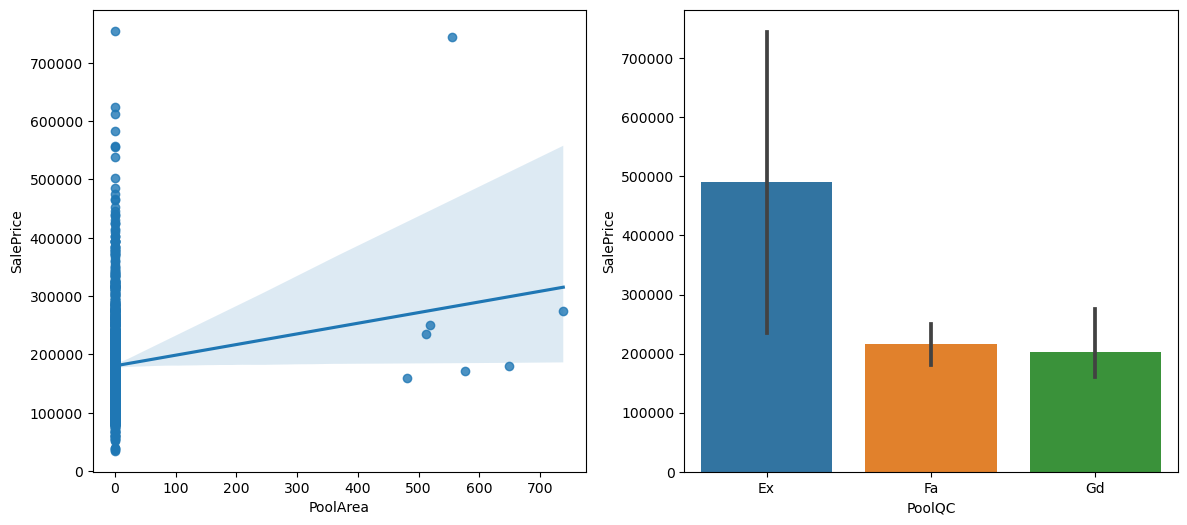

In [114]:
figure, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)
figure.set_size_inches(14,6)
sns.regplot(data = data, x = 'PoolArea', y = 'SalePrice', ax = ax1)
sns.barplot(data = data, x = 'PoolQC', y = 'SalePrice', ax = ax2)

In [115]:
all_data=all_data.drop(columns=['PoolArea','PoolQC'])

<Axes: xlabel='MiscFeature', ylabel='SalePrice'>

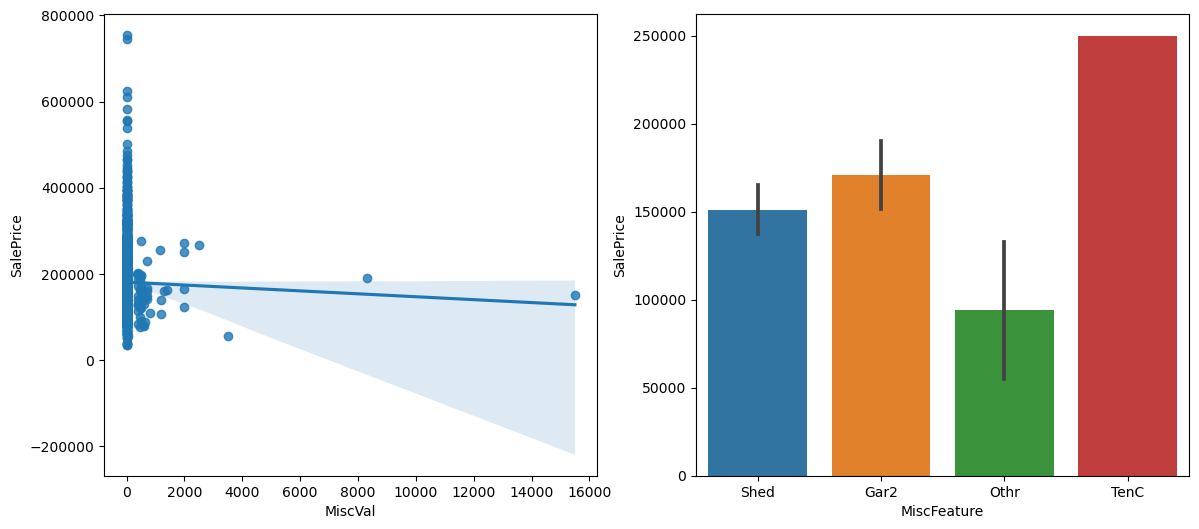

In [116]:
figure, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2)
figure.set_size_inches(14,6)
sns.regplot(data = data, x = 'MiscVal', y = 'SalePrice', ax = ax1)
sns.barplot(data = data, x = 'MiscFeature', y = 'SalePrice', ax = ax2)

In [117]:
all_data=all_data.drop(columns=['MiscVal','MiscFeature'])

#### 채워진 결측치가 많은 경우

<Axes: xlabel='WoodDeckSF', ylabel='SalePrice'>

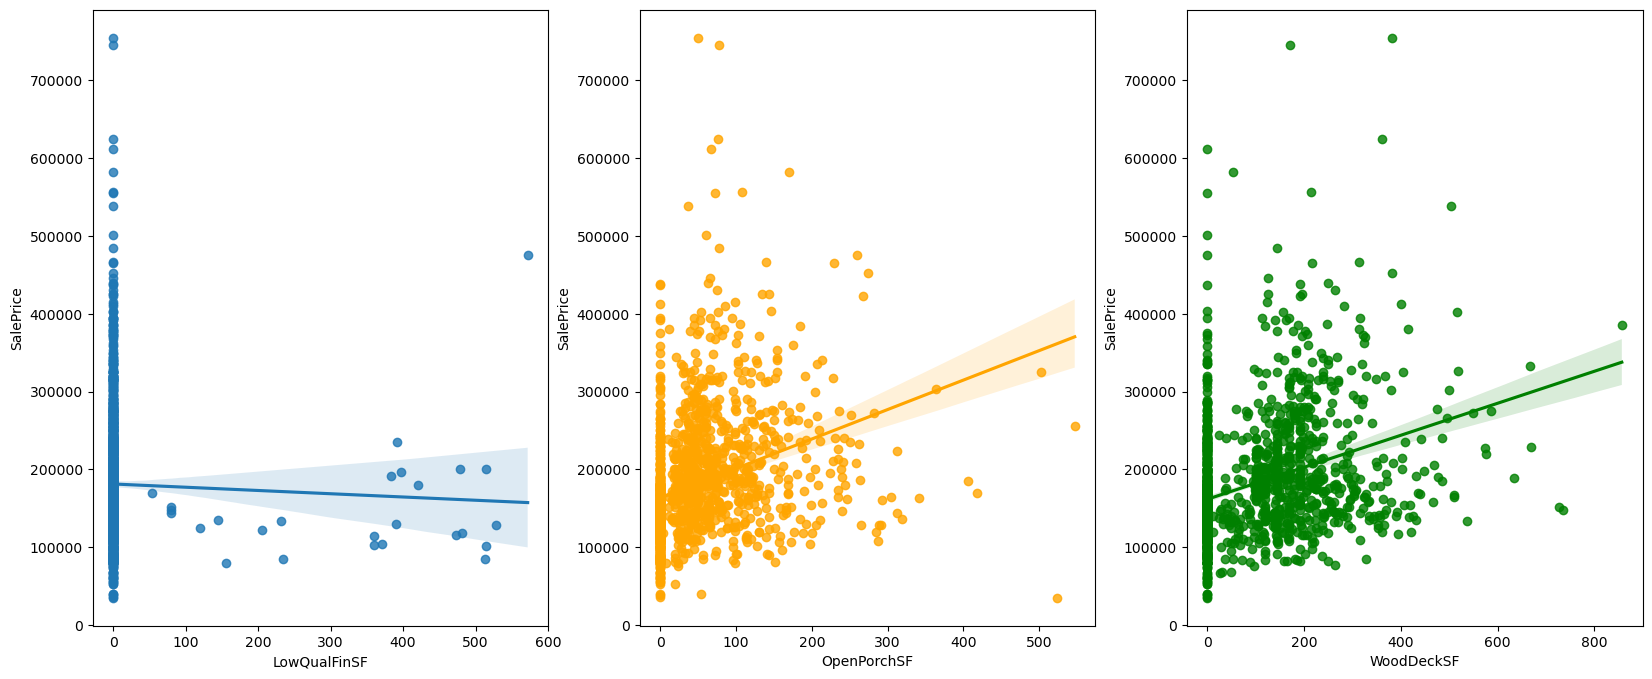

In [123]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3)
figure.set_size_inches(20,8)
sns.regplot(data = data, x = 'LowQualFinSF', y = 'SalePrice', ax = ax1)
sns.regplot(data = data, x = 'OpenPorchSF', y = 'SalePrice', color = 'orange', ax = ax2)
sns.regplot(data = data, x = 'WoodDeckSF', y = 'SalePrice', color = 'green', ax = ax3)

In [124]:
# 0 값을 분리
all_data['NoLowQual'] = (all_data['LowQualFinSF'] == 0)
all_data['NoOpenPorch'] = (all_data['OpenPorchSF'] == 0)
all_data['NoWoodDeck'] = (all_data['WoodDeckSF'] == 0)

#### 전처리

In [125]:
# 범주형 변수들을 모두 원핫 인코딩
non_numeric = all_data.select_dtypes(np.object)

def onehot(col_list):
    global all_data
    while len(col_list) != 0:
        col = col_list.pop(0)
        data_encoded = pd.get_dummies(all_data[col], prefix = col)
        all_data = pd.merge(all_data, data_encoded, on = 'Id')
        all_data = all_data.drop(columns = col)
    print(all_data.shape)
    
onehot(list(non_numeric))

C:\Users\Playdata\AppData\Local\Temp\ipykernel_1976\2981215027.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  non_numeric = all_data.select_dtypes(np.object)


(2917, 304)


In [126]:
# 비대칭도가 높게 나타는 수치형 데이터 처리
numeric = all_data.select_dtypes(np.number)

def log_transform(col_list):
    transformed_col = []
    while len(col_list) != 0:
        col = col_list.pop(0)
        if all_data[col].skew() > 0.5:
            all_data[col] = np.log1p(all_data[col])
            transformed_col.append(col)
        else:
            pass
    print(f"{len(transformed_col)} features had been tranformed")
    print(all_data.shape)

log_transform(list(numeric))

243 features had been tranformed
(2917, 304)


#### 전처리를 한 데이터를 다시 train, test set으로 분리

In [128]:
print(train.shape, test_df.shape)
X_train = all_data[:len(train)]
X_test = all_data[len(train):]
print(X_train.shape, X_test.shape)

(1458, 79) (1459, 79)
(1458, 304) (1459, 304)


In [134]:
y_train = y_train.values

In [135]:
y_train

array([12.24769912, 12.10901644, 12.31717117, ..., 12.49313327,
       11.86446927, 11.90159023])

In [140]:
type(X_train)

pandas.core.frame.DataFrame

In [136]:
# X_train, X_test, y_train
model = Sequential()
model.add(Dense(10, input_dim = X_train.shape[1], activation = 'relu'))
model.add(Dense(30, activation = 'relu'))
model.add(Dense(40, activation = 'relu'))
model.add(Dense(1))
model.summary()
model.compile(optimizer = 'adam', loss = 'mean_squared_error')   #모델을 실행

# 20회 이상 결과가 향상되지 않으면 자동으로 중단
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20)

# 모델의 이름을 정한다
modelpath = '../data/model/house_kagglemodel.hdf5'

#최적화 모델을 업데이트하고 저장
checkpointer = ModelCheckpoint(filepath = modelpath, monitor = 'val_loss', verbose = 0, save_best_only = True)

# 실행관련 설정 - 전체의 20%를 검증셋으로 설정
history = model.fit(X_train, y_train, validation_split = 0.25, epochs = 2000, batch_size = 32, callbacks = [early_stopping_callback, checkpointer])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                3050      
                                                                 
 dense_5 (Dense)             (None, 30)                330       
                                                                 
 dense_6 (Dense)             (None, 40)                1240      
                                                                 
 dense_7 (Dense)             (None, 1)                 41        
                                                                 
Total params: 4661 (18.21 KB)
Trainable params: 4661 (18.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).